<a href="https://colab.research.google.com/github/Roipp16/Health-Data-Science-Repo/blob/main/Stroke_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [63]:
data= pd.read_csv('/stroke.csv')
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [64]:
data = pd.get_dummies(data, columns=['smoking_status'], drop_first=True)

for col in data.select_dtypes(include='object').columns:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

data = data.dropna()

X = data.drop("stroke", axis=1)
y = data["stroke"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [46]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

3927
982
3927
982


We have a big problem with the stroke-no stroke proportion. We will use the oversamplimg technique called SMOTE to create more samples of the minoritary (stroke) class.

We could, otherwise, shortcut the stroke=0 variable so we get the same amount of cases than the stroke=1 group. I will take the first option, though.

In [65]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("Original distribution:", Counter(y))
print("SMOTE distribution:", Counter(y_res))

Original distribution: Counter({0: 4700, 1: 209})
SMOTE distribution: Counter({1: 4700, 0: 4700})


In [48]:
#We can check new distributions and if new data is realistic:
print(sum(y)/len(y))
print(sum(y_res)/len(y_res))


0.04257486249745366
0.5


In [49]:
print("Before SMOTE:")
print(X.describe())

print("\nAfter SMOTE:")
print(X_res.describe())
#we see hypertension mean is on 0.091872 vs 0.086702
#age is 42.865374 vs  54.666961
#this is more or less realistic

Before SMOTE:
                 id       gender          age  hypertension  heart_disease  \
count   4909.000000  4909.000000  4909.000000   4909.000000    4909.000000   
mean   37064.313506     0.410063    42.865374      0.091872       0.049501   
std    20995.098457     0.492309    22.555115      0.288875       0.216934   
min       77.000000     0.000000     0.080000      0.000000       0.000000   
25%    18605.000000     0.000000    25.000000      0.000000       0.000000   
50%    37608.000000     0.000000    44.000000      0.000000       0.000000   
75%    55220.000000     1.000000    60.000000      0.000000       0.000000   
max    72940.000000     2.000000    82.000000      1.000000       1.000000   

       ever_married    work_type  Residence_type  avg_glucose_level  \
count   4909.000000  4909.000000     4909.000000        4909.000000   
mean       0.652679     2.170096        0.507232         105.305150   
std        0.476167     1.092593        0.499999          44.424341   

Since we have quite a lot variables, I will try to get ride of the ones incapable of predicting stroke.

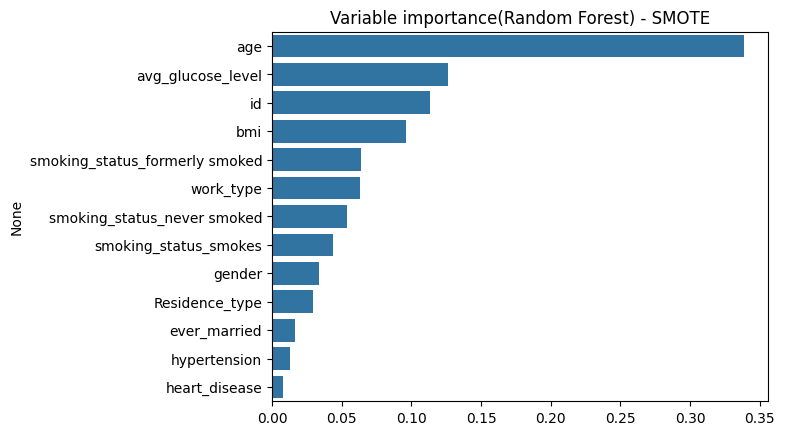

In [66]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
rf_res = RandomForestClassifier(random_state=42)
rf_res.fit(X_res, y_res)

importances_res = rf_res.feature_importances_
features_res = pd.Series(importances_res, index=X_res.columns).sort_values(ascending=False)


sns.barplot(x=features_res.values, y=features_res.index)
plt.title("Variable importance(Random Forest) - SMOTE")
plt.show()


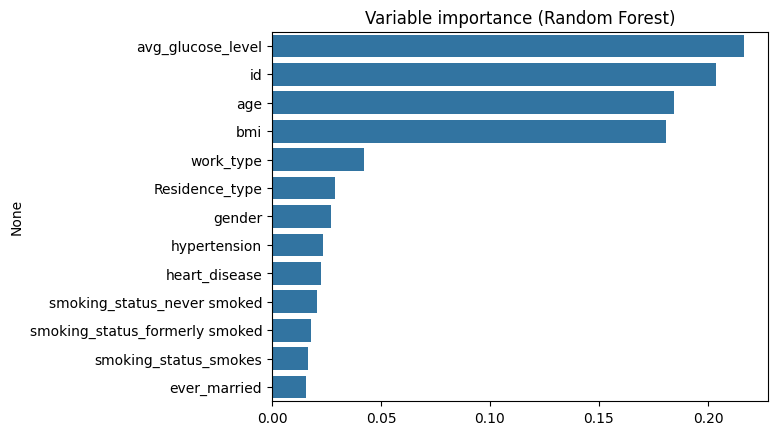

In [67]:
#but what if we had not used SMOTE?
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
features = pd.Series(importances, index=X.columns).sort_values(ascending=False)


sns.barplot(x=features.values, y=features.index)
plt.title("Variable importance (Random Forest)")
plt.show()

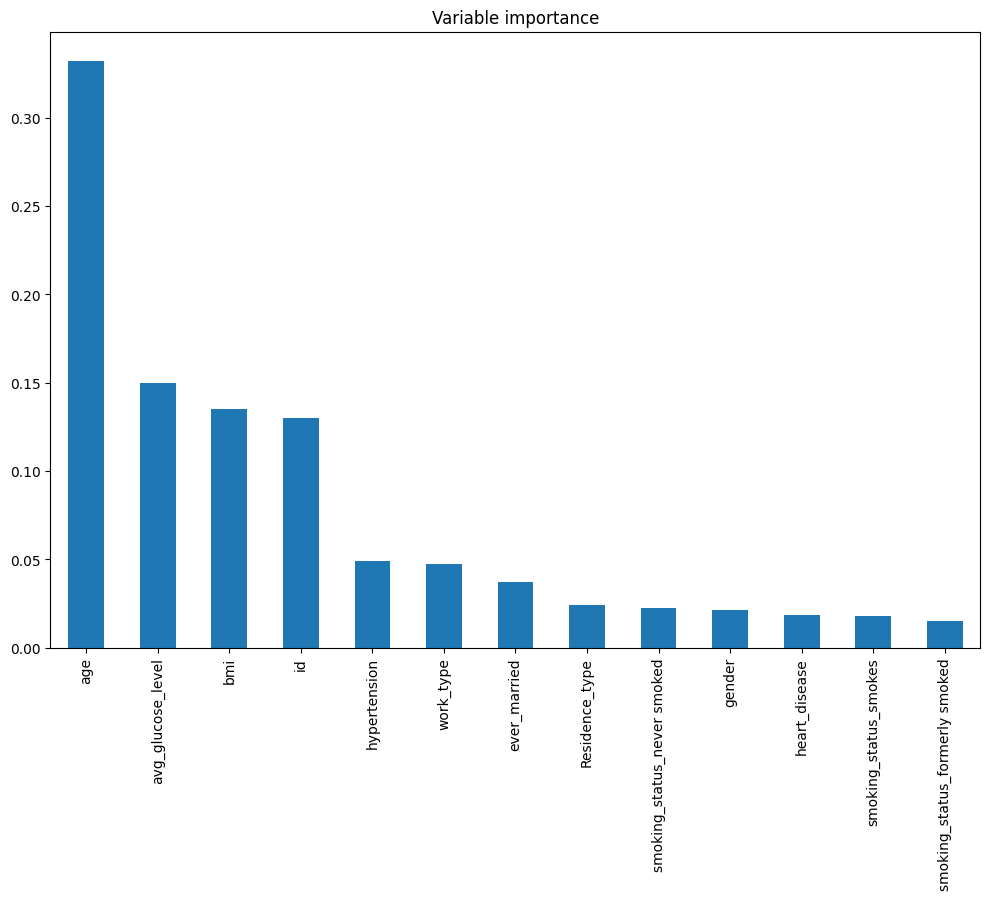

In [68]:
#And what if we had shortcutted the no-stroke subjects?
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


df_stroke = data[data['stroke'] == 1]
df_no_stroke = data[data['stroke'] == 0]


df_no_stroke_balanced = df_no_stroke.sample(n=len(df_stroke), random_state=42)
df_balanced = pd.concat([df_stroke, df_no_stroke_balanced])

X_balanced = df_balanced.drop('stroke', axis=1)
y_balanced = df_balanced['stroke']

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42, n_estimators=100)  # Usamos 100 árboles
rf.fit(X_train, y_train)

importances = rf.feature_importances_
features = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,8))
features.plot(kind='bar')
plt.title("Variable importance")
plt.show()

So we already have some conclusions. We could discard all variables but age, avg_glucose_level and bmi.

We can also compare the different approaches on treating the distribution of groups. We really had no difference between them, so we can say that SMOTE wworked properly.

Now, it's time to predict stroke prevalence.


Accuracy: 0.9439918533604889

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.25      0.02      0.04        53

    accuracy                           0.94       982
   macro avg       0.60      0.51      0.50       982
weighted avg       0.91      0.94      0.92       982



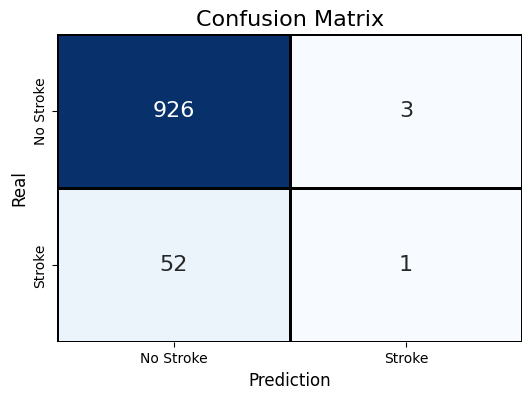

In [60]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = data[['age', 'avg_glucose_level', 'bmi']]
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'], cbar=False, annot_kws={"size": 16}, linewidths=1, linecolor='black')
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()


Here again we have the same issue, too much no-stroke cases that the model can't learn about true stroke cases. Accuracy is so high, though. For sure it is due to the overadapting of the model.

Let's try to use smote here again.

Accuracy: 0.8788187372708758

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       929
           1       0.13      0.23      0.17        53

    accuracy                           0.88       982
   macro avg       0.54      0.57      0.55       982
weighted avg       0.91      0.88      0.89       982



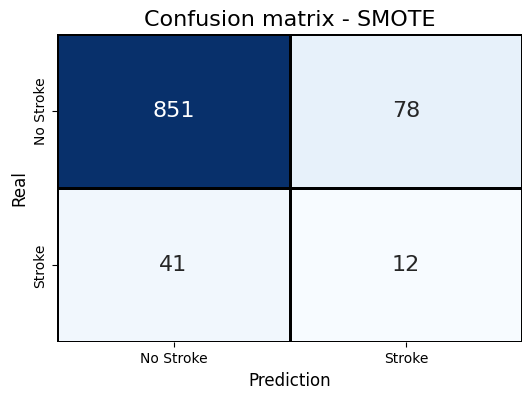

In [59]:

X = data[['age', 'avg_glucose_level', 'bmi']]
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

rf_res = RandomForestClassifier(random_state=42)
rf_res.fit(X_res, y_res)

y_pred_res = rf_res.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_res))
print("\nClassification Report:\n", classification_report(y_test, y_pred_res))

conf_matrix_res = confusion_matrix(y_test, y_pred_res)

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix_res, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'], cbar=False, annot_kws={"size": 16}, linewidths=1, linecolor='black')
plt.title('Confusion matrix - SMOTE', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

In this second one, we can see a few more cases correctly predicted in stroke group. Accuracy is lower, but it is certainly a better model.

We have to bear in mind that in some cases (like this) a false positive is much better than a false negative.

In real-world, the first could do some prevention, even if it is not necessary, and the second won't do anything, however it is highly necessary.